# Preliminaries

In [1]:
import sys
import torch
import numpy as np
import time
import scipy
from scipy import integrate
import time
import pandas as pd
from numba import jit
from numba import complex128
import cmath

In [2]:
from dissipationtheory.constants import ureg, epsilon0, qe, kb, Troom
from dissipationtheory.dissipation9a import CantileverModel, SampleModel1, SampleModel2, SampleModel3
from dissipationtheory.dissipation9b import SampleModel1Jit, SampleModel2Jit, SampleModel3Jit
from dissipationtheory.dissipation9b import integrand1jit, integrand2jit, integrand3jit
from dissipationtheory.dissipation9b import K_jit, Kp
from dissipationtheory.dissipation13e import rpI_jit, rpII_jit, rpIII_jit
from dissipationtheory.dissipation13e import Cmatrix_jit, KmatrixI_jit, KmatrixII_jit, KmatrixIII_jit
from dissipationtheory.dissipation13e import twodimCobject

In [3]:
import torch
import numba as nb
import timeit

In [4]:
ans = {}
args = {}
rpIII = {}
KnIII = {}

In [5]:
t = {}
s = {}
r = {}
q = {}

In [189]:
import matplotlib.pylab as plt
import lmfit
from lmfit.models import LinearModel

In [136]:
THIS = 'dissipation-theory--Study-67--'
figs = {}

Print system version, system platform, and torch version.

In [6]:
print(sys.version, sys.platform, torch.__version__, sep="\n")

3.10.2 | packaged by conda-forge | (main, Mar  8 2022, 15:52:47) [Clang 11.1.0 ]
darwin
2.8.0


# Sample III integrand

Test my bespoke integration scheme in `KmatrixIII_jit` against the packaged integration scheme in `integrate.quad_vec`.  \
Below I am adapting code from Study 64.

In [7]:
def comparetwoK(a, b, label='K'):
    
    for idx, (Ka, Kb) in enumerate(zip(a,b)):

        err_real = (Ka.real-Kb.real)/Ka.real        
        print('Re[{:}[{:d}]] {:+0.9e} vs {:+0.9e}, relative error = {:+3.2e}'.format(
            label, idx, Ka.real, Kb.real, err_real))

    print("")
    for idx, (Ka, Kb) in enumerate(zip(a,b)):
        err_imag = (Ka.imag-Kb.imag)/Ka.imag
        print('Im[{:}[{:d}]] {:+0.9e} vs {:+0.9e}, relative error = {:+3.2e}'.format(
            label,idx, Ka.imag, Kb.imag, err_imag))   

In [8]:
omega = 1e5 * 2 * np.pi

In [9]:
loc1_nm = np.array([  0,  0, 30], dtype=np.float64)
loc2_nm = np.array([  0, 30, 30], dtype=np.float64)

loc1_m = 1e-9 * loc1_nm
loc2_m = 1e-9 * loc2_nm

In [10]:
zjkref = loc1_nm[2] + loc2_nm[2]
x = np.sqrt((loc1_nm[0] - loc2_nm[0])**2 + (loc1_nm[1] - loc2_nm[1])**2) / zjkref

In [11]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(62, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(60, 'nm'),
    angle = ureg.Quantity(20, 'degree'),
    L = ureg.Quantity(1000, 'nm'))

sample3 = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(20, 0), ''),
    sigma = ureg.Quantity(1e-6, 'S/m'),
    rho = ureg.Quantity(1e19, '1/m^3'),
    z_r = ureg.Quantity(1, 'nm'))

sample3_jit = SampleModel3Jit(**sample3.args())

params3_jit = {
    'integrand': integrand3jit, 
    'sample': sample3_jit, 
    'omega': omega, 
    'location1': loc1_m, 
    'location2': loc2_m}

In [12]:
K0, K1, K2 = K_jit(**params3_jit)
KnIII['K_jit'] = np.array([K0, K1, K2])

In [13]:
result = %timeit -o K_jit(**params3_jit)

t[0] = {'method': 'K_jit',
        'size': '1 x 1',
        'time [us]': round(1e6 * result.average, 1)}

1.4 ms ± 28.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
def funcIII(y, x, omega, omega0, zr, kD, es):
    
    def t1(ell):
        return y**ell
    
    t2 = rpIII_jit(y, omega, omega0, zr, kD, es)
    t3 = scipy.special.j0(y * x) * np.exp(-y)
                 
    return np.array(
        [np.real(t1(0) * t2 * t3) / zr,
         np.imag(t1(0) * t2 * t3) / zr,
         np.real(t1(1) * t2 * t3) / zr**2,
         np.imag(t1(1) * t2 * t3) / zr**2,
         np.real(t1(2) * t2 * t3) / zr**3,
         np.imag(t1(2) * t2 * t3) / zr**3])

In [15]:
KnIII['integrate.quad_vec'] = integrate.quad_vec(funcIII,
    0., np.inf,
    args=(x,
        omega,
        params3_jit['sample'].omega0,
        zjkref,
        params3_jit['sample'].kD,
        params3_jit['sample'].epsilon_s))[0] @ Kp

In [16]:
result = %timeit -o integrate.quad_vec(funcIII, \
    0., np.inf, \
    args=(x, \
        omega, \
        params3_jit['sample'].omega0, \
        zjkref, \
        params3_jit['sample'].kD, \
        params3_jit['sample'].epsilon_s))[0] @ Kp

t[1] = {'method': 'integrate.quad_vec',
        'size': '1 x 1',
        'time [us]': round(1e6 * result.average, 1)}

1.65 ms ± 18.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [17]:
comparetwoK(KnIII['K_jit'], KnIII['integrate.quad_vec'])

Re[K[0]] +1.348928697e-02 vs +1.348928697e-02, relative error = -2.57e-16
Re[K[1]] +1.798456068e-04 vs +1.798456068e-04, relative error = +3.01e-16
Re[K[2]] +4.196239541e-06 vs +4.196239541e-06, relative error = +0.00e+00

Im[K[0]] -2.954071435e-06 vs -2.954071435e-06, relative error = +5.26e-13
Im[K[1]] -8.507080519e-09 vs -8.507080519e-09, relative error = +9.23e-13
Im[K[2]] -4.496627345e-11 vs -4.496627345e-11, relative error = +1.46e-13


In [18]:
j0s = scipy.special.jn_zeros(0,100.)
an, _ = scipy.integrate.newton_cotes(20, 1)

In [19]:
args['KmatrixIII_jit'] = {'omega': omega, 
    'omega0': params3_jit['sample'].omega0,
    'kD': params3_jit['sample'].kD,
    'es': params3_jit['sample'].epsilon_s, 
    'sj': np.array([loc1_nm]), # change from list to np.array to avoid deprication warning
    'rk': np.array([loc2_nm]), 
    'j0s': j0s, 
    'an': an,
    'verbose': False,
    'breakpoints': 10}

K0, K1, K2 = KmatrixIII_jit(**args['KmatrixIII_jit'])
KnIII['KmatrixIII_jit'] = np.array([K0[0][0], K1[0][0], K2[0][0]])

In [20]:
result = %timeit -o KmatrixIII_jit(**args['KmatrixIII_jit'])

t[2] = {'method': 'KmatrixIII_jit',
        'size': '1 x 1',
        'time [us]': round(1e6 * result.average,1) }

16.5 µs ± 453 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [21]:
comparetwoK(KnIII['K_jit'], KnIII['KmatrixIII_jit'])

Re[K[0]] +1.348928697e-02 vs +1.348928722e-02, relative error = -1.81e-08
Re[K[1]] +1.798456068e-04 vs +1.798456093e-04, relative error = -1.39e-08
Re[K[2]] +4.196239541e-06 vs +4.196240324e-06, relative error = -1.87e-07

Im[K[0]] -2.954071435e-06 vs -2.954248235e-06, relative error = -5.98e-05
Im[K[1]] -8.507080519e-09 vs -8.509129104e-09, relative error = -2.41e-04
Im[K[2]] -4.496627345e-11 vs -4.497679215e-11, relative error = -2.34e-04


Print out the estimated computation time.

In [22]:
def summarize_times(t):
    
    df = pd.DataFrame(t)
    pd.set_option('display.precision', 3)
    display(df.transpose())

In [23]:
summarize_times(t)

,method,size,time [us]
0,K_jit,1 x 1,1403.8
1,integrate.quad_vec,1 x 1,1652.0
2,KmatrixIII_jit,1 x 1,16.5


# Explore `torch` 

## Reproduce code for the integrand `rpIII_jit` from `dissipation13e.py`.

In [24]:
@jit(complex128(complex128), nopython=True)
def mysech_jit(x):
    """Define my own just-in-time-compiled ``sech()`` function to avoid overflow problems."""
    if x.real < 710.4:
        return 1/np.cosh(x)
    else:
        return complex(0., 0.)
    
@jit(complex128(complex128), nopython=True)
def mycsch_jit(x):
    """Define my own just-in-time-compiled ``csch()`` function to avoid overflow problems."""
    if x.real < 710.4:
        return 1/np.sinh(x)
    else:
        return complex(0., 0.,)

In [25]:
@jit(nopython=True)
def rpIII_jit(y, omega, omega0, zr, kD, es):
    """Fresnel coefficient for Sample III object:

        cantilever | vacuum gap | semiconductor (semi-infinite)
    
    In the code below, `y` is the unitless integration variable.
    """

    Omega = omega/omega0
    k_over_eta = y / np.sqrt(y**2 + (zr * 1e-9 * kD)**2 * (1/es + complex(0,1) * Omega))

    p0 = 1 + complex(0,1) * es * Omega
    p1 = k_over_eta / (es * p0)
    p6 = complex(0,1) * Omega / p0

    theta_norm = p6 + p1
    rp = (1 - theta_norm) / (1 + theta_norm)
 
    return rp

In [26]:
args['rpIII_jit'] = {'y': 2.0, 
    'omega': omega, 
    'omega0': params3_jit['sample'].omega0,
    'zr': zjkref,
    'kD': params3_jit['sample'].kD,
    'es': params3_jit['sample'].epsilon_s}

rpIII['rpIII_jit'] = rpIII_jit(**args['rpIII_jit'])

In [27]:
rpIII['rpIII_jit']

(0.9047761752595673-3.749396688201587e-07j)

In [28]:
%%timeit
rpIII_jit(**args['rpIII_jit'])

225 ns ± 0.915 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [29]:
result = %timeit -o rpIII_jit(**args['rpIII_jit'])

s[1] = {'method': 'rpIII_jit',
        'points': 1,
        'time [us]': round(1e6 * result.average, 2)}

228 ns ± 1.43 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [30]:
summarize_times(s)

,method,points,time [us]
1,rpIII_jit,1,0.23


Based on these timings, we'd expect the following number of function calls for `rpIII_jit` function calls from `KmatrixIII_jit`.

In [31]:
15.4 * 1000 / 333

46.246246246246244

This is in reasonable agreement with (and actually better than) the expected number of operations, $21 \times 10 = 210$.

## Torch implementation of the Coulomb matrix calculation

Start with implimenting the unitless Coulomb matrix, `Cmatrix`, in pytorch.  \
Get some vectors to play with.

In [32]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(60.360, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(57, 'nm'),
    angle = ureg.Quantity(24.2, 'degree'),
    L = ureg.Quantity(2250, 'nm'))

sample3 = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(18.2, -0.1), ''),
    sigma = ureg.Quantity(9.7e-7, 'S/cm'),
    rho = ureg.Quantity(1.9e15, '1/cm^3'),
    z_r = ureg.Quantity(1, 'nm'))

sample3_jit = SampleModel3Jit(**sample3.args())

obj = twodimCobject(sample3_jit)
obj.addtip(h=ureg.Quantity(200, 'nm'))

In [33]:
(obj.sj, obj.rk)

(array([[   0.        ,    0.        ,  200.        ],
        [  30.96094365,    0.        ,  209.14166772],
        [  51.99084662,    0.        ,  233.63438707],
        [  63.91215708,    0.        ,  260.16050584],
        [  69.59370765,    0.        ,  272.80252918],
        [  80.95680878,    0.        ,  298.08657588],
        [  98.00146049,    0.        ,  336.01264591],
        [ 120.72766276,    0.        ,  386.5807393 ],
        [ 149.1354156 ,    0.        ,  449.79085603],
        [ 183.22471901,    0.        ,  525.64299611],
        [ 222.99557298,    0.        ,  614.13715953],
        [ 268.44797752,    0.        ,  715.2733463 ],
        [ 319.58193263,    0.        ,  829.05155642],
        [ 376.39743831,    0.        ,  955.47178988],
        [ 438.89449456,    0.        , 1094.53404669],
        [ 507.07310137,    0.        , 1246.23832685],
        [ 580.93325876,    0.        , 1410.58463035],
        [ 660.47496671,    0.        , 1587.5729572 ],
        [ 

The `Cmatrix_jit` function executes on 21 x 21 inputs in 35 microseconds.

In [34]:
C0 = Cmatrix_jit(obj.sj, obj.rk)
C0.shape

(21, 21)

In [35]:
result = %timeit -o Cmatrix_jit(obj.sj, obj.rk)

r[0] = {'method': 'Cmatrix_jit',
        'notes': '',
        'size': '21 x 21',
        'time [us]': round(1e6 * result.average,1) }

36.1 µs ± 396 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


A function to get the available devices.

In [36]:
def get_device(verbose=False):
    """Select the device to use for tensor computations.  
    Try CUDA/NVIDIA, then MPS, then CPU."""

    if torch.cuda.is_available():
        device = torch.device("cuda")
        if verbose:
            print("Using GPU:", torch.cuda.get_device_name(0))
    else:
        if torch.backends.mps.is_available():
            device = torch.device("mps")
            if verbose:
                print("Using MPS (Apple Silicon GPU)")
        else:
            device = torch.device("cpu") 
            if verbose:
                print("Using CPU")
    
    return device

In [37]:
device = get_device(verbose=True)

Using MPS (Apple Silicon GPU)


Use the torch function suggested by Visual Studio Codes' AI. 

In [38]:
torch.set_printoptions(precision=8)

In [39]:
@torch.compile
def Cmatrix_torch(sj, rk, device):
    """Torch-compatible unitless Coulomb potential Green's function matrix."""
    sj = torch.as_tensor(sj.astype(np.float32), device=device)
    rk = torch.as_tensor(rk.astype(np.float32), device=device)
    result = torch.zeros((sj.shape[0], rk.shape[0]), dtype=sj.dtype)
    for j, sje in enumerate(sj):
        for k, rke in enumerate(rk):
            result[j, k] = 1 / torch.linalg.norm(sje - rke)
    return result

The torch function returns the right-sized object.

In [40]:
C1 = Cmatrix_torch(obj.sj, obj.rk, device)
C1.shape

torch.Size([21, 21])

The torch function gives the expected result.

In [41]:
C1 = Cmatrix_torch(obj.sj, obj.rk, device).cpu().numpy()
np.allclose(C0, C1)

True

The *compiled* torch code is 1000-fold slower than my numba-compiled function `Cmatrix_jit`.  \
Ouch!

In [42]:
result = %timeit -o Cmatrix_torch(obj.sj, obj.rk, device)

r[1] = {'method': 'Cmatrix_torch',
        'notes': 'loops',
        'size': '21 x 21',
        'time [us]': round(1e6 * result.average,1) }

47.8 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


However, the function has loops. \
See if we can make a faster torch function.

Ok, create a torch function in a different way. \
Write a function for two vectors, and then `vmap` it.

In [43]:
sj_torch = torch.as_tensor(obj.sj.astype(np.float32), device=device)
rk_torch = torch.as_tensor(obj.rk.astype(np.float32), device=device)

Look at the shape of the resulting tensors.

In [44]:
(sj_torch.shape, rk_torch.shape)

(torch.Size([21, 3]), torch.Size([21, 3]))

Define a function to compute the unitless Coulomb function for two vectors.

In [45]:
def C_torch(sj, rk):
    return 1/torch.linalg.vector_norm(sj - rk)

In [46]:
_ = C_torch(sj_torch[0], rk_torch[0])

This function is quite fast.

In [47]:
result = %timeit -o C_torch(sj_torch[0], rk_torch[0])

r[2] = {'method': 'Cmatrix_torch',
        'notes': 'uncompiled',
        'size': '1 x 1',
        'time [us]': round(1e6 * result.average,1)}

29.8 µs ± 209 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [48]:
@torch.compile
def C_torch(sj, rk):
    return 1/torch.linalg.vector_norm(sj - rk)

In [49]:
_ = C_torch(sj_torch[0], rk_torch[0])

In [50]:
result = %timeit -o C_torch(sj_torch[0], rk_torch[0])

r[3] = {'method': 'Cmatrix_torch',
        'notes': 'compiled',
        'size': '1 x 1',
        'time [us]': round(1e6 * result.average,1)}

13 µs ± 14.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Applying this function to two vectors, we get the expected result. \
Remember that we have to pull the result back from the GPU onto the CPU and convert the a numpy array.

In [51]:
print((C_torch(sj_torch[0], rk_torch[0]).cpu().numpy(), C0[0][0]))
np.allclose(C_torch(sj_torch[0], rk_torch[0]).cpu().numpy(), C0[0][0])

(array(0.01976312, dtype=float32), 0.019763126391352342)


True

Now try to get the full 21 x 21 array by mapping.


Skim the [youtube](https://www.youtube.com/@MrPSolver) channel of "MrPSolver". Review the video "GPU-Accelerated Ideal Gas Law Simulation" ([youtube](https://youtu.be/2XckqFzUiYU?si=wgbbdFqCrZ2XpJQv)); look at his code at [github](https://github.com/lukepolson/youtube_channel/tree/main/Python%20GPU). \
Consult with departmental colleague Eric Thiede.

Based on Eric's suggested code:

In [52]:
Cmatrix_torch = torch.vmap(torch.vmap(C_torch, (None, 0)),(0, None))

The mapped Coulomb matrix function gives a matrix with the expected size.

In [53]:
C2 = Cmatrix_torch(sj_torch, rk_torch).cpu().numpy()
C2.shape

(21, 21)

Moreover, we get the correct answer.

In [54]:
np.allclose(C2, C0)

True

The timing is much improved, and quite good, within a factor of two of my `Cmatrix_jit` function. \

In [55]:
result = %timeit -o Cmatrix_torch(sj_torch, rk_torch)

r[4] = {'method': 'Cmatrix_torch',
        'notes': 'vmap',
        'size': '21 x 21',
        'time [us]': round(1e6 * result.average,1)}

64.1 µs ± 661 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


It takes about 175 microseconds to get the 21 x 21 matrix of data off GPU and back onto the CPU.

In [56]:
result = %timeit -o Cmatrix_torch(sj_torch, rk_torch).cpu().numpy()

r[5] = {'method': 'Cmatrix_torch',
        'notes': 'vmap, .cpu().numpy()',
        'size': '21 x 21',
        'time [us]': round(1e6 * result.average,1)}

229 µs ± 2.36 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Summarize the run-time fundings.

In [57]:
summarize_times(r)

,method,notes,size,time [us]
0,Cmatrix_jit,,21 x 21,36.1
1,Cmatrix_torch,loops,21 x 21,47846.4
2,Cmatrix_torch,uncompiled,1 x 1,29.8
3,Cmatrix_torch,compiled,1 x 1,13.0
4,Cmatrix_torch,vmap,21 x 21,64.1
5,Cmatrix_torch,"vmap, .cpu().numpy()",21 x 21,229.3


The time to execute `.cpu().numpy()`, and get the data of the GPU and onto the CPU, is

In [58]:
print('{:0.0f} us'.format(
    r[5]['time [us]'] - 
    r[4]['time [us]']))

165 us


Interesting!

## Torch implimentation of $r_p$ for a Type III sample

In [59]:
summarize_times(s)

,method,points,time [us]
1,rpIII_jit,1,0.23


Try to write a torch version of the `rpIII` function.

In [60]:
def rpIII_torch(y: torch.tensor, omega: float, omega0: float, zr: float, kD: float, es: complex) -> torch.complex128:
    """Fresnel coefficient for Sample III object: 

        cantilever | vacuum gap | semiconductor (semi-infinite)
    
    In the code below, `y` is the unitless integration variable.
    """

    Omega = omega/omega0
    k_over_eta = y / torch.sqrt(y**2 + (zr * 1e-9 * kD)**2 * (1/es + complex(0,1) * Omega))

    p0 = 1 + complex(0,1) * es * Omega
    p1 = k_over_eta / (es * p0)
    p6 = complex(0,1) * Omega / p0

    theta_norm = p6 + p1
    rp = (1 - theta_norm) / (1 + theta_norm)
 
    return rp

In [61]:
args['rpIII_torch_A'] = {'y': torch.tensor([2.0], dtype=torch.float64), 
    'omega': omega, 
    'omega0': params3_jit['sample'].omega0,
    'zr': zjkref,
    'kD': params3_jit['sample'].kD,
    'es': params3_jit['sample'].epsilon_s}

In [62]:
rpIII['rpIII_torch_A'] = rpIII_torch(**args['rpIII_torch_A'])
rpIII['rpIII_torch_A']

tensor([0.90477618-3.74939669e-07j], dtype=torch.complex128)

In [63]:
result = %timeit -o rpIII_torch(**args['rpIII_torch_A'])

s[2] = {'method': 'rpIII_torch',
        'points': 1,
        'time [us]': round(1e6 * result.average,2)}

11.9 µs ± 137 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


We can use the `comparetwoK` function to compare the jit and torch results.

In [64]:
comparetwoK([rpIII['rpIII_jit']],[rpIII['rpIII_torch_A'][0].cpu().numpy()], label='rpIII')

Re[rpIII[0]] +9.047761753e-01 vs +9.047761753e-01, relative error = -1.23e-16

Im[rpIII[0]] -3.749396688e-07 vs -3.749396688e-07, relative error = -2.62e-13


Hey, the results are really nice!

Let's see if it's any faster.

In [65]:
summarize_times(s)

,method,points,time [us]
1,rpIII_jit,1,0.23
2,rpIII_torch,1,11.92


Ok, slower, ugh.

But let's see how torch scales with number of data points.  \
Try it with 315 points.

In [66]:
args['rpIII_torch_B'] = {'y': torch.tensor(np.linspace(-5, 5, 315), dtype=torch.float64), 
    'omega': omega, 
    'omega0': params3_jit['sample'].omega0,
    'zr': zjkref,
    'kD': params3_jit['sample'].kD,
    'es': params3_jit['sample'].epsilon_s}

Run it once before timing it.

In [67]:
rpIII['rpIII_torch_B'] = rpIII_torch(**args['rpIII_torch_B'])

In [68]:
result = %timeit -o rpIII_torch(**args['rpIII_torch_B'])

s[3] = {'method': 'rpIII_torch',
        'points': 315,
        'time [us]': round(1e6 * result.average,2)}

15.2 µs ± 77.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [69]:
summarize_times(s)

,method,points,time [us]
1,rpIII_jit,1,0.23
2,rpIII_torch,1,11.92
3,rpIII_torch,315,15.18


Each integration involves at least $21 * 15 = 315$ function evaluations. \
For 315 evaluations, the torch computation takes approximately the same amount of time as 1 evaluation. \
For 315 computations, we'd estimate that the analogous jit computation would take $0.21 \,{\mu\mathrm{s}} \times 315 = 66 \, \mu\mathrm{s}$. \
So for 315 evaluations, the torch computation GPU is faster than the jit CPU computation by a factor of about 4.

Surprising! \
I hypothesize that torch computations have large overhead but very favorable scaling.

## Torch implimentation of  $K_n$  for a Type III sample

We next to implement an integration scheme like the one in `KmatrixIII_jit`. \
We want a torch calculation like the one below.

In [70]:
K0, K1, K2 = KmatrixIII_jit(**args['KmatrixIII_jit'])
KnIII['KmatrixIII_jit'] = np.array([K0[0][0], K1[0][0], K2[0][0]])

Do this in two steps.

1. make an integrator, then
2. use `torch.vmap` to feed the integrator pairs of points like we did for C_matrix above.

Ok, first the integrator.  We wish to replace the function

    KmatrixIII_jit(omega, omega0, kD, es, sj, rk, j0s, an, verbose=False, breakpoints=10)
    
Inside this function, we need to integrate

    rpIII_torch(omega: float, omega0: float, zr: float, kD: float, es: complex) -> torch.complex128

Let's see if we can integrate brute force. \
Build up the integral in pieces before writing it into a function.

In [71]:
omega0 = params3_jit['sample'].omega0
kD = params3_jit['sample'].kD
es = params3_jit['sample'].epsilon_s
sj = torch.as_tensor(loc1_nm.astype(np.float32), device=device)
rk = torch.as_tensor(loc2_nm.astype(np.float32), device=device)
pts = 3000

In [72]:
y_min = 2.0e-9
y_max = 2.0e+1

In [73]:
w = torch.linspace(
    torch.log(torch.tensor(y_min)),
    torch.log(torch.tensor(y_max)),
    pts,
    device=device)

In [74]:
zjkref = sj[2] + rk[2]
x = torch.sqrt((sj[0] - rk[0])**2 + (sj[1] - rk[1])**2) / zjkref

(zjkref, x)

(tensor(60., device='mps:0'), tensor(0.50000000, device='mps:0'))

In [75]:
t0 = torch.exp(w)
t1 = torch.exp(w - t0)
t2 = torch.special.bessel_j0(t0 * x)
t3 = rpIII_torch(t0, omega, omega0, zjkref, kD, es)

In [76]:
((t0[0], t0[-1]),
 (t1[0], t1[-1]),
 (t2[0], t2[-1]),
 (t3[0], t3[-1]))

((tensor(1.99999950e-09, device='mps:0'), tensor(19.99998093, device='mps:0')),
 (tensor(1.99999950e-09, device='mps:0'),
  tensor(4.12238208e-08, device='mps:0')),
 (tensor(1., device='mps:0'), tensor(-0.24593535, device='mps:0')),
 (tensor(0.90476888-0.00081514j, device='mps:0'),
  tensor(0.90476209+1.05592146e-10j, device='mps:0')))

In [77]:
I0 = t1 * t2 * t3
I1 = t0 * I0
I2 = t0 * I1

In [78]:
K0 = torch.trapezoid(y=I0, x=w) / zjkref**1
K1 = torch.trapezoid(y=I1, x=w) / zjkref**2
K2 = torch.trapezoid(y=I2, x=w) / zjkref**3

In [79]:
KnIII['rp_III_integrator_torch_try'] = torch.tensor([K0, K1, K2])
KnIII['rp_III_integrator_torch_try']

tensor([1.34892864e-02-2.95407108e-06j, 1.79845607e-04-8.50707771e-09j,
        4.19624030e-06-4.49662460e-11j])

Compare results to the $K_n$'s computed using `integrate.quad_vec` integration of $r_p$.

In [80]:
comparetwoK(KnIII['integrate.quad_vec'], KnIII['rp_III_integrator_torch_try'])

Re[K[0]] +1.348928697e-02 vs +1.348928642e-02, relative error = +6.90e-08
Re[K[1]] +1.798456068e-04 vs +1.798456069e-04, relative error = +0.00e+00
Re[K[2]] +4.196239541e-06 vs +4.196240297e-06, relative error = -2.17e-07

Im[K[0]] -2.954071435e-06 vs -2.954071078e-06, relative error = +1.54e-07
Im[K[1]] -8.507080519e-09 vs -8.507077709e-09, relative error = +3.13e-07
Im[K[2]] -4.496627345e-11 vs -4.496624600e-11, relative error = +6.17e-07


Wow, the agreement is pretty good!

Now turn the code into a function. \
Wrap the call variables in a dictionary.

In [81]:
args['rp_III_integrator_torch'] = {'omega': omega, 
    'omega0': params3_jit['sample'].omega0,
    'kD': params3_jit['sample'].kD,
    'es': params3_jit['sample'].epsilon_s, 
    'sj': sj,
    'rk': rk,
    'pts': 500,
    'device': device}

Here is the function, based on the above code.

In [82]:
def rp_III_integrator_torch(
    omega: float,
    omega0: float,
    kD: float,
    es: complex,
    sj: torch.tensor,
    rk: torch.tensor,
    pts: int,
    device: torch.device) -> torch.tensor:
    
    y_min = 2.0e-9
    y_max = 2.0e+1
    
    w = torch.linspace(
        torch.log(torch.tensor(y_min)),
        torch.log(torch.tensor(y_max)),
        pts,
        device=device)
    
    zjkref = sj[2] + rk[2]
    x = torch.sqrt((sj[0] - rk[0])**2 + (sj[1] - rk[1])**2) / zjkref
    
    t0 = torch.exp(w)
    t1 = torch.exp(w - t0)
    t2 = torch.special.bessel_j0(t0 * x)
    t3 = rpIII_torch(t0, omega, omega0, zjkref, kD, es)
    
    I0 = t1 * t2 * t3
    I1 = t0 * I0
    I2 = t0 * I1
    
    K0 = torch.trapezoid(y=I0, x=w) / zjkref**1
    K1 = torch.trapezoid(y=I1, x=w) / zjkref**2
    K2 = torch.trapezoid(y=I2, x=w) / zjkref**3    
    
    return torch.tensor([K0, K1, K2])

It runs!

In [83]:
rp_III_integrator_torch(**args['rp_III_integrator_torch'])

tensor([1.34892864e-02-2.95407131e-06j, 1.79845607e-04-8.50708126e-09j,
        4.19624030e-06-4.49663085e-11j])

In [84]:
KnIII['rp_III_integrator_torch'] = \
    rp_III_integrator_torch(**args['rp_III_integrator_torch'])

Compare results to the $K_n$'s computed using `integrate.quad_vec` integration of $r_p$.

In [85]:
comparetwoK(KnIII['integrate.quad_vec'], KnIII['rp_III_integrator_torch'])

Re[K[0]] +1.348928697e-02 vs +1.348928642e-02, relative error = +6.90e-08
Re[K[1]] +1.798456068e-04 vs +1.798456069e-04, relative error = +0.00e+00
Re[K[2]] +4.196239541e-06 vs +4.196240297e-06, relative error = -2.17e-07

Im[K[0]] -2.954071435e-06 vs -2.954071306e-06, relative error = +7.70e-08
Im[K[1]] -8.507080519e-09 vs -8.507081262e-09, relative error = -1.04e-07
Im[K[2]] -4.496627345e-11 vs -4.496630845e-11, relative error = -7.72e-07


We get the same results as above, indicating that we introduced no coding errors.

In [86]:
result = %timeit -o rp_III_integrator_torch(**args['rp_III_integrator_torch'])

s[4] = {'method': 'rp_III_integrator_torch',
        'points': 500,
        'time [us]': round(1e6 * result.average, 2)}

825 µs ± 4.31 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


For comparison, let's scale uup `rpIII_jit` to 500 points.

In [87]:
s[5] = {'method': 'rp_III_jit (extrapolated)',
        'points': int(s[4]['points']),
        'time [us]': round(s[4]['points'] * s[1]['time [us]'], 2)}

Compare the execution time to prior calculations.

In [88]:
summarize_times(s)

,method,points,time [us]
1,rpIII_jit,1,0.23
2,rpIII_torch,1,11.92
3,rpIII_torch,315,15.18
4,rp_III_integrator_torch,500,825.07
5,rp_III_jit (extrapolated),500,115.0


How to make a threaded version?

In [89]:
def rp_III_integrator_torch(
    omega: float,
    omega0: float,
    kD: float,
    es: complex,
    sj: torch.tensor,
    rk: torch.tensor,
    pts: int,
    device: torch.device) -> torch.tensor:
    
    y_min = 2.0e-9
    y_max = 2.0e+1
    
    w = torch.linspace(
        torch.log(torch.tensor(y_min)),
        torch.log(torch.tensor(y_max)),
        pts,
        device=device)
    
    zjkref = sj[2] + rk[2]
    x = torch.sqrt((sj[0] - rk[0])**2 + (sj[1] - rk[1])**2) / zjkref
    
    t0 = torch.exp(w)
    t1 = torch.exp(w - t0)
    t2 = torch.special.bessel_j0(t0 * x)
    t3 = rpIII_torch(t0, omega, omega0, zjkref, kD, es)
    
    I0 = t1 * t2 * t3
    I1 = t0 * I0
    I2 = t0 * I1
    
    K0 = torch.trapezoid(y=I0, x=w) / zjkref**1
    K1 = torch.trapezoid(y=I1, x=w) / zjkref**2
    K2 = torch.trapezoid(y=I2, x=w) / zjkref**3    
    
    return [K0, K1, K2]  # Works if this is a list but NOT a torch.tensor()

In [90]:
KmatrixIII_torch = torch.vmap(
    torch.vmap(
        rp_III_integrator_torch, 
        in_dims=(None, None, None, None, None, 0, None, None), out_dims=0),
    in_dims=(None, None, None, None, 0, None, None, None), out_dims=0)

This works, but *only* if `rp_III_integrator_torch` returns a scalar or a list, *not* a torch.tensor.

In [91]:
(sj_torch.shape, rk_torch.shape)

(torch.Size([21, 3]), torch.Size([21, 3]))

In [92]:
K0torch, K1torch, K2torch = KmatrixIII_torch(omega, omega0, kD, es, sj_torch, rk_torch, pts, device)
(K0torch.shape, K1torch.shape, K2torch.shape)

(torch.Size([21, 21]), torch.Size([21, 21]), torch.Size([21, 21]))

What to compare it to?

In [93]:
args['KmatrixIII_jit_many'] = {'omega': omega, 
    'omega0': params3_jit['sample'].omega0,
    'kD': params3_jit['sample'].kD,
    'es': params3_jit['sample'].epsilon_s, 
    'sj': obj.sj, 
    'rk': obj.rk, 
    'j0s': j0s, 
    'an': an,
    'verbose': False,
    'breakpoints': 15}

K0jit, K1jit, K2jit =  KmatrixIII_jit(**args['KmatrixIII_jit_many'])

Wow, the answers are equal to within machine precision!

In [94]:
(np.allclose(K0jit, K0torch.cpu()),
 np.allclose(K1jit, K1torch.cpu()),
 np.allclose(K2jit, K2torch.cpu()))

(True, True, True)

What is the runtime?

In [126]:
result = %timeit -o KmatrixIII_torch(omega, omega0, kD, es, sj_torch, rk_torch, pts, device)

q[0] = {'method': 'KmatrixIII_torch',
        'N': 21,
        'size': 21 * 21,
        'time [ms]': round(1e3 * result.average,1)}

5.45 ms ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


This should be compared to

In [127]:
result = %timeit -o KmatrixIII_jit(**args['KmatrixIII_jit_many'])

q[1] = {'method': 'KmatrixIII_jit',
        'N': 21,
        'size': 21 * 21,
        'time [ms]': round(1e3 * result.average,1)}

7.36 ms ± 221 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [128]:
summarize_times(q)

,method,N,size,time [ms]
0,KmatrixIII_torch,21,441,5.5
1,KmatrixIII_jit,21,441,7.4
2,KmatrixIII_torch,21,441,5.4
3,KmatrixIII_torch,41,1681,18.5
4,KmatrixIII_torch,61,3721,20.0
5,KmatrixIII_torch,81,6561,37.4


They are of comparable speed, with the torch method being *slightly* faster.

# Scaling of the `KmatrixIII_torch` function

Let's see how the execution time of the torch function for computing the $K_n$ matrices scales with the size $N$ of the $s_j$ and $r_k$ vectors.

In [129]:
for index, N in zip([2, 3, 4, 5], [21, 41, 61, 81, 101]):

    print(index, N)
    
    sj_torch_rand = torch.randint(low=20, high=30, size=(N, 3), device=device)
    rk_torch_rand = torch.randint(low=20, high=30, size=(N, 3), device=device)

    _, _, _ = KmatrixIII_torch(omega, omega0, kD, es, sj_torch_rand, rk_torch_rand, pts, device)

    result = %timeit -o KmatrixIII_torch(omega, omega0, kD, es, sj_torch_rand, rk_torch_rand, pts, device)

    q[index] = {'method': 'KmatrixIII_torch',
                'N': N,
                'size': N * N,
                'time [ms]': round(1e3 * result.average,1)}

2 21
5.46 ms ± 35.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
3 41
18.5 ms ± 3.2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
4 61
41.3 ms ± 5.49 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
5 81
63.8 ms ± 5.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [133]:
summarize_times(q)

,method,N,size,time [ms]
0,KmatrixIII_torch,21,441,5.5
1,KmatrixIII_jit,21,441,7.4
2,KmatrixIII_torch,21,441,5.5
3,KmatrixIII_torch,41,1681,18.5
4,KmatrixIII_torch,61,3721,41.3
5,KmatrixIII_torch,81,6561,63.8


Make a plot.

In [134]:
dq = pd.DataFrame(q).transpose()
dq2 = dq[dq['method'] == 'KmatrixIII_torch']
dq2

,method,N,size,time [ms]
0,KmatrixIII_torch,21,441,5.5
2,KmatrixIII_torch,21,441,5.5
3,KmatrixIII_torch,41,1681,18.5
4,KmatrixIII_torch,61,3721,41.3
5,KmatrixIII_torch,81,6561,63.8


In [218]:
def plotme(df):
    
    fig = plt.figure(figsize=(3.25, 3.50))
    
    gmodel = LinearModel()
    gmodel.make_params(offset=0, slope=0.01)
    out = gmodel.fit(df['time [ms]'], x=df['size'])    
    
    args = {'markerfacecolor': 'white', 
            'markeredgecolor': 'black', 
            'markersize': 6, 
            'color': 'black'}
    
    fig = out.plot(
        xlabel='number of points $N$',
        ylabel='run time [ms]',
        title=' ', 
        fig=fig,
        data_kws=args)
    
    fig.axes[1].get_legend().remove() 
    
    plt.gca().set_ylim(bottom=0)
    plt.gca().set_xlim(left=0)
    
    fig.align_ylabels()
    fig.tight_layout()
    
    return out, fig

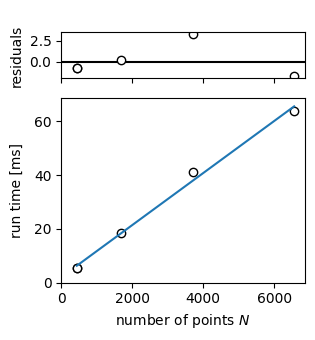

In [219]:
out, figs['01'] = plotme(dq2)

Print out the best-fit slope and intercept.

In [235]:
for par in out.params:

  print("{:} = {:0.4f} +/- {:0.4f}".format(
    par,
    out.params[par].value,
    out.params[par].stderr))

slope = 0.0097 +/- 0.0004
intercept = 2.0501 +/- 1.4846


Use the best-fit slope and intercept to estimate the run time needed to compute 

- a 20-point BLDS spectrum assuming 
- a finite-time model where the $K$ matrices are of size $21 \times 21$.


In [236]:
print(f"{out.params['intercept'].value + (21 * 21 * 40) * out.params['slope'].value: 0.0f} ms")

 173 ms


If we could achieve this run time, it would represent a factor of 100 improvement over the 30 seconds required now.

For completeness, print out all the fit results.

In [221]:
out.result

# Conclusions

I have sucessfully written torch functions for computing

1. the Coulomb matrix and
2. the $K_n$ matrices for a Type III sample. 

These functions give the expected results. They run slightly faster than their numba-compiled counterparts, and their run time scales gently with the number of computations.

::: {.content-hidden when-format="html"}

# Save the figures

In [222]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-67.ipynb && open dissipation-theory--Study-67.html
    
:::